In [42]:
import torch 
from torch import nn 
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

In [43]:
augmentation1 = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmentation2 = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [44]:
class BYOLDataset(Dataset):
    def __init__(self, base_dataset, transform1, transform2):
        self.base_dataset = base_dataset
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx] 
        x1 = self.transform1(img)
        x2 = self.transform2(img)
        return x1, x2

In [45]:
dataset_path = "./dataset"
base_dataset = datasets.ImageFolder(root=dataset_path)
byol_dataset = BYOLDataset(base_dataset, augmentation1, augmentation2)
dataloader = torch.utils.data.DataLoader(byol_dataset, batch_size=256, shuffle=True)

In [46]:
data_iter = iter(dataloader)
x1, x2 = next(data_iter)
print(x1.shape) 
print(x2.shape) 


torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])


In [47]:
data_iter = iter(dataloader)
images, labels = next(data_iter)
images.shape

torch.Size([256, 1, 28, 28])

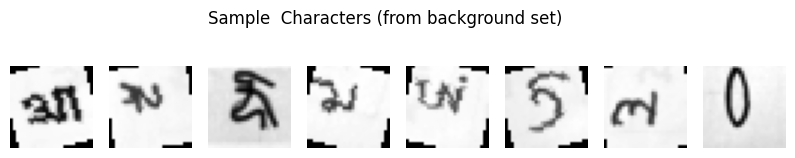

In [48]:
plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i].squeeze(0).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample  Characters (from background set)")
plt.show()

In [49]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim=64, out_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 14x14

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 7x7

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 3x3

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # -> 1x1
        )
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.encoder(x)          # Shape: (B, hidden_dim, 1, 1)
        x = x.view(x.size(0), -1)    # Flatten to (B, hidden_dim)
        return self.fc(x)           

In [50]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [51]:
class OnlineNetwork(nn.Module):
    def __init__(self, encoder, feature_dim=64, proj_hidden_dim=128, proj_out_dim=128):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(feature_dim, proj_hidden_dim, proj_out_dim)
        self.predictor = MLP(proj_out_dim, proj_hidden_dim // 2, proj_out_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        predictions = self.predictor(projections)
        return predictions, projections

In [52]:
class TargetNetwork(nn.Module):
    def __init__(self, encoder, feature_dim=64, proj_hidden_dim=256, proj_out_dim=256):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(feature_dim, proj_hidden_dim, proj_out_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return projections


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [54]:
encoder = Encoder()

online_net = OnlineNetwork(encoder, feature_dim=64, proj_hidden_dim=128, proj_out_dim=128)
target_net = TargetNetwork(encoder, feature_dim=64, proj_hidden_dim=128, proj_out_dim=128)
online_net.to(device)
target_net.to(device)

TargetNetwork(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(64, eps=1e-05, mo

In [55]:
def loss_fn(p, z):
    p = F.normalize(p, dim=-1)
    z = F.normalize(z.detach(), dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1).mean()

In [56]:
@torch.no_grad()
def update_target_network(online_net, target_net, beta=0.996):
    for param_o, param_t in zip(online_net.parameters(), target_net.parameters()):
        param_t.data = beta * param_t.data + (1 - beta) * param_o.data

In [57]:
# Count parameters
def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

def count_parameters_by_layer(model):
    """Count parameters by layer and show detailed breakdown"""
    total_params = 0
    trainable_params = 0
    
    print("Parameter count by layer:")
    print("-" * 50)
    
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
            print(f"{name}: {param_count:,} parameters (trainable)")
        else:
            print(f"{name}: {param_count:,} parameters (frozen)")
    
    print("-" * 50)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    
    return total_params, trainable_params

# Count parameters for online network
print("ONLINE NETWORK PARAMETER COUNT:")
print("=" * 50)
total_params, trainable_params = count_parameters_by_layer(online_net)

# Also show a simple count
simple_count = count_parameters(online_net)
print(f"\nSimple parameter count: {simple_count:,}")

# Convert to millions for easier reading
print(f"Parameters in millions: {simple_count / 1e6:.2f}M")

ONLINE NETWORK PARAMETER COUNT:
Parameter count by layer:
--------------------------------------------------
encoder.encoder.0.weight: 576 parameters (trainable)
encoder.encoder.0.bias: 64 parameters (trainable)
encoder.encoder.1.weight: 64 parameters (trainable)
encoder.encoder.1.bias: 64 parameters (trainable)
encoder.encoder.4.weight: 36,864 parameters (trainable)
encoder.encoder.4.bias: 64 parameters (trainable)
encoder.encoder.5.weight: 64 parameters (trainable)
encoder.encoder.5.bias: 64 parameters (trainable)
encoder.encoder.8.weight: 36,864 parameters (trainable)
encoder.encoder.8.bias: 64 parameters (trainable)
encoder.encoder.9.weight: 64 parameters (trainable)
encoder.encoder.9.bias: 64 parameters (trainable)
encoder.encoder.12.weight: 36,864 parameters (trainable)
encoder.encoder.12.bias: 64 parameters (trainable)
encoder.encoder.13.weight: 64 parameters (trainable)
encoder.encoder.13.bias: 64 parameters (trainable)
encoder.fc.weight: 4,096 parameters (trainable)
encoder.fc

In [58]:
lr = 1e-5
weight_decay = 1e-6  
epochs = 100

optimizer = torch.optim.Adam(online_net.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, verbose=True
)

online_net = online_net.to(device)
target_net = target_net.to(device)
target_net.eval()

best_loss = float('inf')
epoch_losses = [] 

for epoch in range(epochs):
    online_net.train()
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")

    for x1, x2 in loop:
        x1, x2 = x1.to(device), x2.to(device)

        optimizer.zero_grad()

        # Online forward
        p1, z1 = online_net(x1)

        with torch.no_grad():
            z2 = target_net(x2)

        loss1 = loss_fn(p1, z2)

        # Second view
        p2, z2_online = online_net(x2)

        with torch.no_grad():
            z1_target = target_net(x1)

        loss2 = loss_fn(p2, z1_target)

        # Total loss
        loss = (loss1 + loss2) / 2
        loss.backward()
        optimizer.step()

        # Update target net
        update_target_network(online_net, target_net, beta=0.996)

        total_loss += loss.item()
        avg_loss = total_loss / (loop.n + 1)
        loop.set_postfix(loss=avg_loss)

    # Epoch average loss
    total_loss_epoch = total_loss / len(dataloader)
    epoch_losses.append(total_loss_epoch)  # Save for plotting
    print(f"Epoch {epoch+1} Final Avg Loss: {total_loss_epoch:.4f}")

    # Step the scheduler
    scheduler.step(total_loss_epoch)

    # Save best model
    if total_loss_epoch < best_loss:
        best_loss = total_loss_epoch
        torch.save(target_net.encoder.state_dict(), 'best_model.pth')

print("\nBest Validation Loss:", best_loss)


Epoch [1/100]: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s, loss=1.81]


Epoch 1 Final Avg Loss: 1.8148


Epoch [2/100]: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=1.7] 


Epoch 2 Final Avg Loss: 1.7045


Epoch [3/100]: 100%|██████████| 35/35 [00:32<00:00,  1.07it/s, loss=1.62]


Epoch 3 Final Avg Loss: 1.6212


Epoch [4/100]: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=1.55]


Epoch 4 Final Avg Loss: 1.5463


Epoch [5/100]: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s, loss=1.48]


Epoch 5 Final Avg Loss: 1.4751


Epoch [6/100]: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s, loss=1.42]


Epoch 6 Final Avg Loss: 1.4186


Epoch [7/100]: 100%|██████████| 35/35 [00:31<00:00,  1.10it/s, loss=1.38]


Epoch 7 Final Avg Loss: 1.3770


Epoch [8/100]: 100%|██████████| 35/35 [00:31<00:00,  1.10it/s, loss=1.34]


Epoch 8 Final Avg Loss: 1.3408


Epoch [9/100]: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s, loss=1.3] 


Epoch 9 Final Avg Loss: 1.2975


Epoch [10/100]: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s, loss=1.26]


Epoch 10 Final Avg Loss: 1.2553


Epoch [11/100]: 100%|██████████| 35/35 [00:31<00:00,  1.10it/s, loss=1.22]


Epoch 11 Final Avg Loss: 1.2186


Epoch [12/100]: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s, loss=1.18]


Epoch 12 Final Avg Loss: 1.1818


Epoch [13/100]: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s, loss=1.14]


Epoch 13 Final Avg Loss: 1.1440


Epoch [14/100]: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s, loss=1.11]


Epoch 14 Final Avg Loss: 1.1056


Epoch [15/100]: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s, loss=1.06]


Epoch 15 Final Avg Loss: 1.0636


Epoch [16/100]: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s, loss=1.02]


Epoch 16 Final Avg Loss: 1.0219


Epoch [17/100]: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s, loss=0.983]


Epoch 17 Final Avg Loss: 0.9829


Epoch [18/100]: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s, loss=0.946]


Epoch 18 Final Avg Loss: 0.9462


Epoch [19/100]: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s, loss=0.911]


Epoch 19 Final Avg Loss: 0.9113


Epoch [20/100]: 100%|██████████| 35/35 [00:32<00:00,  1.09it/s, loss=0.877]


Epoch 20 Final Avg Loss: 0.8775


Epoch [21/100]: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s, loss=0.844]


Epoch 21 Final Avg Loss: 0.8444


Epoch [22/100]: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s, loss=0.81] 


Epoch 22 Final Avg Loss: 0.8104


Epoch [23/100]: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s, loss=0.778]


Epoch 23 Final Avg Loss: 0.7784


Epoch [24/100]: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=0.749]


Epoch 24 Final Avg Loss: 0.7489


Epoch [25/100]: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=0.719]


Epoch 25 Final Avg Loss: 0.7189


Epoch [26/100]: 100%|██████████| 35/35 [00:35<00:00,  1.01s/it, loss=0.691]


Epoch 26 Final Avg Loss: 0.6912


Epoch [27/100]: 100%|██████████| 35/35 [00:35<00:00,  1.03s/it, loss=0.664]


Epoch 27 Final Avg Loss: 0.6637


Epoch [28/100]: 100%|██████████| 35/35 [00:34<00:00,  1.03it/s, loss=0.635]


Epoch 28 Final Avg Loss: 0.6348


Epoch [29/100]: 100%|██████████| 35/35 [00:35<00:00,  1.01s/it, loss=0.608]


Epoch 29 Final Avg Loss: 0.6077


Epoch [30/100]: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=0.581]


Epoch 30 Final Avg Loss: 0.5811


Epoch [31/100]: 100%|██████████| 35/35 [00:32<00:00,  1.07it/s, loss=0.556]


Epoch 31 Final Avg Loss: 0.5562


Epoch [32/100]: 100%|██████████| 35/35 [00:34<00:00,  1.03it/s, loss=0.532]


Epoch 32 Final Avg Loss: 0.5316


Epoch [33/100]: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s, loss=0.505]


Epoch 33 Final Avg Loss: 0.5053


Epoch [34/100]: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=0.482]


Epoch 34 Final Avg Loss: 0.4815


Epoch [35/100]: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s, loss=0.461]


Epoch 35 Final Avg Loss: 0.4609


Epoch [36/100]: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it, loss=0.439]


Epoch 36 Final Avg Loss: 0.4388


Epoch [37/100]: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s, loss=0.417]


Epoch 37 Final Avg Loss: 0.4175


Epoch [38/100]: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s, loss=0.398]


Epoch 38 Final Avg Loss: 0.3983


Epoch [39/100]: 100%|██████████| 35/35 [00:35<00:00,  1.01s/it, loss=0.377]


Epoch 39 Final Avg Loss: 0.3767


Epoch [40/100]: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=0.36] 


Epoch 40 Final Avg Loss: 0.3597


Epoch [41/100]: 100%|██████████| 35/35 [00:35<00:00,  1.03s/it, loss=0.342]


Epoch 41 Final Avg Loss: 0.3416


Epoch [42/100]: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.324]


Epoch 42 Final Avg Loss: 0.3241


Epoch [43/100]: 100%|██████████| 35/35 [00:34<00:00,  1.00it/s, loss=0.308]


Epoch 43 Final Avg Loss: 0.3077


Epoch [44/100]: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=0.293]


Epoch 44 Final Avg Loss: 0.2933


Epoch [45/100]: 100%|██████████| 35/35 [00:33<00:00,  1.03it/s, loss=0.28] 


Epoch 45 Final Avg Loss: 0.2801


Epoch [46/100]: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=0.266]


Epoch 46 Final Avg Loss: 0.2656


Epoch [47/100]: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=0.254]


Epoch 47 Final Avg Loss: 0.2538


Epoch [48/100]: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=0.241]


Epoch 48 Final Avg Loss: 0.2413


Epoch [49/100]: 100%|██████████| 35/35 [00:34<00:00,  1.00it/s, loss=0.231]


Epoch 49 Final Avg Loss: 0.2309


Epoch [50/100]: 100%|██████████| 35/35 [00:35<00:00,  1.00s/it, loss=0.218]


Epoch 50 Final Avg Loss: 0.2177


Epoch [51/100]: 100%|██████████| 35/35 [00:34<00:00,  1.03it/s, loss=0.207]


Epoch 51 Final Avg Loss: 0.2072


Epoch [52/100]: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=0.2]  


Epoch 52 Final Avg Loss: 0.2000


Epoch [53/100]: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.187]


Epoch 53 Final Avg Loss: 0.1872


Epoch [54/100]: 100%|██████████| 35/35 [00:35<00:00,  1.01s/it, loss=0.18] 


Epoch 54 Final Avg Loss: 0.1798


Epoch [55/100]: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it, loss=0.171]


Epoch 55 Final Avg Loss: 0.1706


Epoch [56/100]: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.162]


Epoch 56 Final Avg Loss: 0.1621


Epoch [57/100]: 100%|██████████| 35/35 [00:41<00:00,  1.18s/it, loss=0.156]


Epoch 57 Final Avg Loss: 0.1556


Epoch [58/100]: 100%|██████████| 35/35 [00:34<00:00,  1.03it/s, loss=0.147]


Epoch 58 Final Avg Loss: 0.1472


Epoch [59/100]: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s, loss=0.141]


Epoch 59 Final Avg Loss: 0.1409


Epoch [60/100]: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s, loss=0.133]


Epoch 60 Final Avg Loss: 0.1330


Epoch [61/100]: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it, loss=0.13] 


Epoch 61 Final Avg Loss: 0.1302


Epoch [62/100]: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it, loss=0.122]


Epoch 62 Final Avg Loss: 0.1215


Epoch [63/100]: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.116]


Epoch 63 Final Avg Loss: 0.1160


Epoch [64/100]: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it, loss=0.114]


Epoch 64 Final Avg Loss: 0.1136


Epoch [65/100]: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.107]


Epoch 65 Final Avg Loss: 0.1067


Epoch [66/100]: 100%|██████████| 35/35 [00:37<00:00,  1.08s/it, loss=0.098] 


Epoch 66 Final Avg Loss: 0.0980


Epoch [67/100]: 100%|██████████| 35/35 [00:35<00:00,  1.01s/it, loss=0.0991]


Epoch 67 Final Avg Loss: 0.0991


Epoch [68/100]: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.0984]


Epoch 68 Final Avg Loss: 0.0984


Epoch [69/100]: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.0895]


Epoch 69 Final Avg Loss: 0.0895


Epoch [70/100]: 100%|██████████| 35/35 [00:38<00:00,  1.11s/it, loss=0.0883]


Epoch 70 Final Avg Loss: 0.0883


Epoch [71/100]: 100%|██████████| 35/35 [00:37<00:00,  1.08s/it, loss=0.0818]


Epoch 71 Final Avg Loss: 0.0818


Epoch [72/100]: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.0808]


Epoch 72 Final Avg Loss: 0.0808


Epoch [73/100]: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s, loss=0.0777]


Epoch 73 Final Avg Loss: 0.0777


Epoch [74/100]: 100%|██████████| 35/35 [00:35<00:00,  1.03s/it, loss=0.0709]


Epoch 74 Final Avg Loss: 0.0709


Epoch [75/100]: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s, loss=0.0706]


Epoch 75 Final Avg Loss: 0.0706


Epoch [76/100]: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s, loss=0.0685]


Epoch 76 Final Avg Loss: 0.0685


Epoch [77/100]: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it, loss=0.0711]


Epoch 77 Final Avg Loss: 0.0711


Epoch [78/100]: 100%|██████████| 35/35 [00:35<00:00,  1.01s/it, loss=0.063] 


Epoch 78 Final Avg Loss: 0.0630


Epoch [79/100]: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.0626]


Epoch 79 Final Avg Loss: 0.0626


Epoch [80/100]: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.0625]


Epoch 80 Final Avg Loss: 0.0625


Epoch [81/100]: 100%|██████████| 35/35 [00:37<00:00,  1.08s/it, loss=0.062] 


Epoch 81 Final Avg Loss: 0.0620


Epoch [82/100]: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.0583]


Epoch 82 Final Avg Loss: 0.0583


Epoch [83/100]: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.0539]


Epoch 83 Final Avg Loss: 0.0539


Epoch [84/100]: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.0534]


Epoch 84 Final Avg Loss: 0.0534


Epoch [85/100]: 100%|██████████| 35/35 [00:40<00:00,  1.15s/it, loss=0.0583]


Epoch 85 Final Avg Loss: 0.0583


Epoch [86/100]: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it, loss=0.0549]


Epoch 86 Final Avg Loss: 0.0549


Epoch [87/100]: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it, loss=0.0507]


Epoch 87 Final Avg Loss: 0.0507


Epoch [88/100]: 100%|██████████| 35/35 [00:37<00:00,  1.08s/it, loss=0.0492]


Epoch 88 Final Avg Loss: 0.0492


Epoch [89/100]: 100%|██████████| 35/35 [00:38<00:00,  1.09s/it, loss=0.0464]


Epoch 89 Final Avg Loss: 0.0464


Epoch [90/100]: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it, loss=0.0479]


Epoch 90 Final Avg Loss: 0.0479


Epoch [91/100]: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.0501]


Epoch 91 Final Avg Loss: 0.0501


Epoch [92/100]: 100%|██████████| 35/35 [00:43<00:00,  1.23s/it, loss=0.0484]


Epoch 92 Final Avg Loss: 0.0484


Epoch [93/100]: 100%|██████████| 35/35 [00:44<00:00,  1.27s/it, loss=0.046] 


Epoch 93 Final Avg Loss: 0.0460


Epoch [94/100]: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it, loss=0.0451]


Epoch 94 Final Avg Loss: 0.0451


Epoch [95/100]: 100%|██████████| 35/35 [00:39<00:00,  1.12s/it, loss=0.0457]


Epoch 95 Final Avg Loss: 0.0457


Epoch [96/100]: 100%|██████████| 35/35 [00:42<00:00,  1.20s/it, loss=0.0419]


Epoch 96 Final Avg Loss: 0.0419


Epoch [97/100]: 100%|██████████| 35/35 [00:37<00:00,  1.08s/it, loss=0.0439]


Epoch 97 Final Avg Loss: 0.0439


Epoch [98/100]: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.0437]


Epoch 98 Final Avg Loss: 0.0437


Epoch [99/100]: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it, loss=0.0413]


Epoch 99 Final Avg Loss: 0.0413


Epoch [100/100]: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.0402]

Epoch 100 Final Avg Loss: 0.0402

Best Validation Loss: 0.04017105272838047


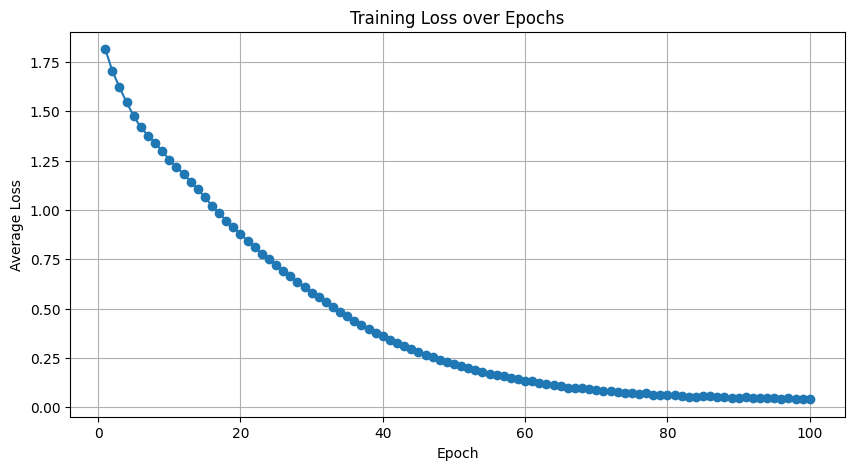

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()